In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import cauchy, norm, uniform, beta

# Monte Carlo estimation of the Cauchy distribution scale

Assume the [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution). For its heavy tails, this distribution is popular in outliers modeling. The outliers, naturally, corrupt the data and may spoil the parameters inference. In addition, its mean and higher moments are [undefined](https://en.wikipedia.org/wiki/Cauchy_distribution#Explanation_of_undefined_moments), which essentially means that there is no reasonable arithmetic average of the data, nor the sample variance.

### Model
Assume $Y_i \sim \mathit{Cauchy}(\gamma)$, where $\gamma$ is the scale parameter:

$$
f(y_i|\gamma) = \frac{1}{\pi \gamma \left(1 + \frac{y_i}{\gamma}\right)^2}
$$


#### Data simulation
Let's simulate some data and investigate the sample mean and variance. Note that the distribution is centered at zero:

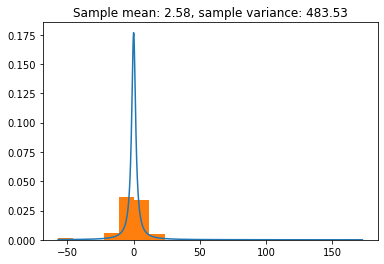

In [2]:
ndat = 100
scale = 1.8
x = cauchy.rvs(scale=scale, size=ndat)
xticks = np.linspace(x.min(), x.max(), 1000)
plt.plot(xticks, cauchy.pdf(xticks, scale=scale))
plt.hist(x, density=True, bins=20)
plt.title(f'Sample mean: {x.mean():.2f}, sample variance: {x.var():.2f}')
plt.show()

### Prior distribution for $\gamma$

There is no convenient conjugate prior for the estimation of the scale parameter $\gamma$. For the sake of simplicity, let's use $\gamma \sim \mathcal{U}(a,b)$ where $a>0$. The resulting pdf hence reads

$$
p(\gamma) = \frac{1}{b-a}.
$$

Remark: Since $\pi=3.1415\ldots$ is used in the Cauchy pdf, we'll denote the prior by $p()$.

### Posterior distribution

From the Bayes' theorem,

$$
\begin{aligned}
p(\gamma|y_{1:n}) &\propto p(\gamma) \cdot \prod_{i=1}^{n} f(y_i|\gamma) \\
&\propto \frac{1}{b-a} \cdot \prod_{i=1}^{n} \frac{1}{\pi \gamma \left(1 + \frac{y_i}{\gamma}\right)^2}.
\end{aligned}
$$

Let's remark that pdf values are tiny, hence we will use logarithms in the sequel!

In [3]:
def posterior_pdf(gamma, a, b, data):
    product = np.log(1/(b-a)) 
    product += np.sum(cauchy.logpdf(data, scale=gamma))
    return np.exp(product)

Let's plot the posterior distribution to see how it looks like and whether it seems that its support covers the value of $\gamma$ (we can study what happens if not). Note that the posterior below is not normalized, but we should remember that this doesn't matter in rejection sampling.

In [8]:
a = 0.1
b = 4.
gammas = np.linspace(a, b, 100)
post = [posterior_pdf(gamma, a=a, b=b, data=x) for gamma in gammas]
post = np.array(post)

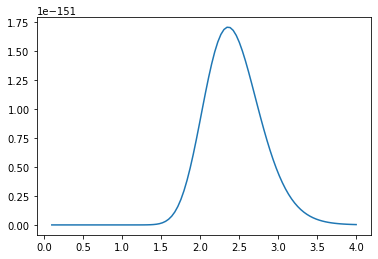

In [9]:
plt.plot(gammas, post)

So we know how the posterior looks like. Now, let's calculate the point estimate of $\gamma$ and it's uncertainty (variance):

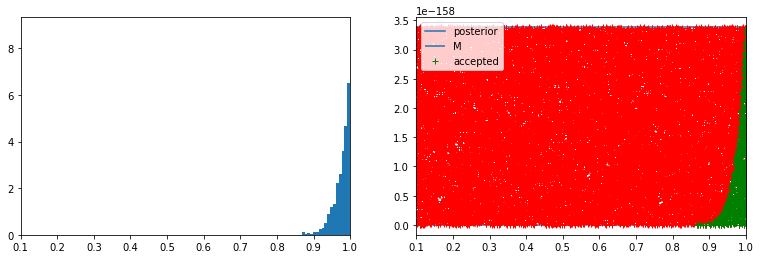

In [6]:
nsamples = 30000     ### Number of samples
M = post.max()       ### M
samples_gamma = uniform.rvs(a, b, size=nsamples)    # proposal samples
samples_u = uniform.rvs(0., M, size=nsamples)       # uniform samples
p_gamma = np.array([posterior_pdf(sample, a=a, b=b, data=x) for sample in samples_gamma]) # value of f(x)
accepted = np.where(samples_u < p_gamma)[0]

plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.hist(samples_gamma[accepted], bins=30, density=True)
plt.xlim(a, b)
plt.subplot(122)
xticks = np.linspace(a, b, 100)
plt.plot(gammas, post, label='posterior')
plt.hlines(M, xticks.min(), xticks.max(), label='M')
plt.plot(samples_gamma, samples_u, 'r+')
plt.plot(samples_gamma[accepted], samples_u[accepted], 'g+', label='accepted')
plt.xlim(a, b)
plt.legend()
plt.show()

In [7]:
print(f"Acceptance: {100*accepted.size/nsamples:.2f}% ({accepted.size} of {nsamples})")
print(f"Point estimate E[gamma] = {samples_gamma[accepted].mean():.2f}")
print(f"Var(gamma) = {samples_gamma[accepted].var():.2f}")
print(f'True gamma was {scale}')

Acceptance: 12.54% (3763 of 30000)
Point estimate E[gamma] = 1.04
Var(gamma) = 0.00
True gamma was 1.8
